In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import imageio as igio
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy as scpy

In [3]:
def my_mse( A, B):
#     if( A.shape != B.shape):
#         print('Both matrixes are of same dimensions\n')
    counter = 0
    for i in range(0,A.shape[0]):
        for j in range(0,A.shape[1]):
            counter += (A[i,j]- B[i,j])*(A[i,j]- B[i,j])
#     print( 'mse:', np.sqrt(counter/A.shape[0]*A.shape[1]) ) 
    return np.sqrt(counter/(A.shape[0]*A.shape[1]))

In [4]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # the np.where() function returns the indices for all coordinates 
        # in some array matching the condition. In this case, all pixels
        # that have value 'i'
        pixels_value_i = np.where(A == i)
        
        #print(pixels_value_i)  # uncomment to print array of coordinates
        
        # by counting how many coordinates the np.where function returned, 
        # we can assign it at the respective histogram bin
        # this is done by getting the size of the vector of coordinates
        hist[i] = pixels_value_i[0].shape[0]
            
    return(hist)

In [5]:
#size of the denoising filter kernel (if type 1) or size of degradation function (if
#type 2), k ∈ [3, 5, 7, 9, 11],
#Afterwards, if the type of filter is 1 (denoising), get the following input:
# • mode for denoising mode = "average" or "robust",
# Otherwise, if the type of filter is 2 (deblurring), then
# • sigma for the degradation function σ > 0.

def my_min(im):
    m_min = 256
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if( im[i,j] < m_min ):
                m_min = im[i,j]
    return m_min
    
def my_max(im):
    m_max = -1
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if( im[i,j] > m_max ):
                m_max = im[i,j]
    return m_max

def my_scale( img_orig, img_dest  ):
    img_scaled = np.zeros(img_dest.shape)
    
    a = my_min(img_orig)
    b = my_max(img_orig)
    
    img_dest_min = my_min(img_dest)
    img_dest_max = my_max(img_dest)
    
    for i in range(img_dest.shape[0]):
        for j in range(img_dest.shape[1]):
            img_scaled[i,j] = (b - a)*(img_dest[i,j]-img_dest_min)/(img_dest_max-img_dest_min) + a
    
    return img_scaled

def my_fun(name_reference, name_degraded, F, gamma, size_denoising_filter, denoising_type, sigma ):
    
    img_reference =igio.imread(name_reference)
#     print(img_reference.shape)
    img_degraded =igio.imread(name_degraded)
#     print(img_degraded.shape)
    
    img_f = np.zeros(img_degraded.shape)
#     print(img_f.shape)
    
    ##Copy of values with no filter passing
    img_f[0, 0:img_reference.shape[1]-1] = img_reference[0, 0:img_reference.shape[1]-1]
    img_f[img_reference.shape[0]-1, 0:img_reference.shape[1]-1] = img_reference[img_reference.shape[0]-1, 0:img_reference.shape[1]-1]
    
    img_f[0:img_reference.shape[0]-1, 0] = img_reference[0:img_reference.shape[0]-1, 0]
    img_f[0:img_reference.shape[0]-1, img_reference.shape[1]-1] = img_reference[0:img_reference.shape[0]-1, img_reference.shape[1]-1]
#     print(img_f)
    
    ##Clarify disp_n is only calculates on [0,1/6*m], [0,1/6*n]
    x_d = int(np.floor(img_degraded.shape[0]/6)) ##Clarify what is m or n???
    y_d = int(np.floor(img_degraded.shape[1]/6))
    
    n_range = np.zeros([1, x_d*y_d])
    idx = 0
    disp_n = -1
    for x in range(0,x_d):
        for y in range(0,y_d):
            n_range[0, idx] = img_degraded[x,y]
            idx += 1
        if(denoising_type == 'average'):
            disp_n = np.std(n_range)
        elif(denoising_type == 'robust'):
            disp_n = np.percentile(n_range, 75, interpolation='higher') - np.percentile(n_range, 25, interpolation='lower')
    
    ##Error Checking disp_n
    if disp_n == 0:
        disp_n = 1
    
#     print('disp_n ', disp_n)
    
    centr_l = -1
    ##Adaptative Denoising
    for i in range(1, img_degraded.shape[0]-2):
        for j in range(1, img_degraded.shape[1]-2):
            
            ##Calculate disp_l
            val = int(np.floor(size_denoising_filter.shape[1]/2))
                
            l_range = np.zeros([1, int(size_denoising_filter.shape[0]*size_denoising_filter.shape[1]) - 1])
            
            idx = 0
            
            inc_i = -val
#             print('i j : ', i, j)
            for n_i in range(0, size_denoising_filter.shape[0]):
                inc_j = -val
                for n_j in range(0, size_denoising_filter.shape[1]):
                    if( not(n_i == 1 & n_j == 1) ):
                        l_range[0, idx] = img_degraded[i + inc_i, j + inc_j]
#                         print(l_range)
                        idx += 1
                    inc_j += 1
                inc_i += 1
            
            if(denoising_type == 'average'):
                centr_l = np.std(l_range)
            elif(denoising_type == 'robust'):
                centr_l = np.percentile(l_range, 75, interpolation='higher') - np.percentile(l_range, 25, interpolation='lower')
            
            disp_l = np.std(l_range)
            
            ##Error checking
            if (disp_l == 0):
                disp_l = disp_n
            
            ##Calculate centr_l
            centr_l = 0
            if(denoising_type == 'average'):
                centr_l = np.average(l_range)
            elif(denoising_type == 'robust'):
                centrl_l = np.median(l_range)
            
            
            img_f[i,j] = img_degraded[i,j] - gamma * disp_n/disp_l * (img_degraded[i,j] - centr_l)
            
#     igio.imwrite('im_ori.png', img_f.astype('uint8'))
    
#     img_f = my_scale(img_reference, img_f)
#     igio.imwrite('im_norm.png', img_f.astype('uint8'))
#     print(img_f.shape)
    
    return img_f

In [6]:
def gaussian_filter(k=5,sigma=1.0):
    arx=np.arange((-k//2)+1.0,(k//2)+1.0)
    x,y=np.meshgrid(arx,arx)
    filt=np.exp(-(1/2)*(np.square(x)+np.square(y))/np.square(sigma))
    return filt/np.sum(filt)

def center_padding(H_u, g_filter):
    inc = int(np.floor(g_filter.shape[0]/2))
    x = int(np.floor(H_u.shape[0]/2))
    y = int(np.floor(H_u.shape[1]/2))
    H_u[ x - inc:x + inc+1, y - inc:y+inc+1 ] = g_filter
    return H_u

def dislocar(G_u):
    G_u_tmp = np.copy(G_u)
    inc_x = int(np.floor(G_u.shape[0]/2))
    inc_y = int(np.floor(G_u.shape[1]/2))

    G_u[0:inc_x, 0:inc_y] = G_u_tmp[inc_x:G_u.shape[0], inc_y:G_u.shape[1]]

    G_u[0:inc_x, 0:inc_y] = G_u_tmp[inc_x:G_u.shape[0], inc_y:G_u.shape[1]]
    G_u[inc_x:G_u.shape[0], inc_y:G_u.shape[1]] = G_u_tmp[0:inc_x, 0:inc_y]
    
    G_u[0:inc_x, inc_y:G_u.shape[1]] = G_u_tmp[inc_x:G_u.shape[0], 0:inc_y]
    G_u[inc_x:G_u.shape[0], 0:inc_y] = G_u_tmp[0:inc_x, inc_y:G_u.shape[1]]
    
    return G_u

In [19]:
from scipy.fftpack import fft, ifft

def my_fun1(name_reference, name_degraded, F, gamma, size_denoising_filter, sigma ):
    
    img_reference =igio.imread(name_reference)
    img_degraded =igio.imread(name_degraded)
    
#     print('img_r', img_reference.shape)
#     print('img_d', img_degraded.shape)
    
    f = np.zeros(img_reference.shape)
#     print('f', f.shape)
    
    g_filter = gaussian_filter(size_denoising_filter, sigma)
    H_u = np.zeros(img_reference.shape)
    H_u = center_padding(H_u, g_filter) 
#     print('H_u', H_u.shape)

    p_u = np.array([ [0, -1, 0], [-1, 4, -1], [0, -1, 0] ])
    P_u = np.zeros(img_reference.shape)
    P_u = center_padding(P_u, p_u)
#     print('P_u', P_u.shape)

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(H_u, cmap = 'gray')
    plt.subplot(1,2,2)
    plt.imshow(P_u, cmap = 'gray')

    H_u = fft(H_u)
#     H_u = dislocar(H_u)
    
#     print('fH_u', H_u.shape)
    P_u = fft(P_u)
#     P_u = dislocar(P_u)
    
#     print('fP_u', P_u.shape)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(H_u.real, cmap = 'gray')
    plt.subplot(1,4,2)
    plt.imshow(H_u.imag, cmap = 'gray')


    plt.subplot(1,4,3)
    plt.imshow(P_u.real, cmap = 'gray')
    plt.subplot(1,4,4)
    plt.imshow(P_u.imag, cmap = 'gray')

    H_u_ = np.conjugate(H_u)
#     print('H_u_', H_u_.shape)
    G_u = fft(img_degraded)
#     print('G_u', G_u.shape)
    gamma = 0.00005

    plt.figure(figsize=(10,10))
    plt.subplot(1,6,1)
    plt.imshow(img_degraded, cmap = 'gray')

    plt.subplot(1,6,2)
    plt.imshow(ifft(G_u).real, cmap = 'gray')
    G_u = dislocar(G_u)
    plt.subplot(1,6,3)
    plt.imshow(G_u.real, cmap = 'gray')
    plt.subplot(1,6,4)
    plt.imshow(G_u.imag, cmap = 'gray')

    for i in range(0,f.shape[0]):
        for j in range(0,f.shape[1]):
            f[i,j] = ( H_u_[i,j] / ( np.square(np.abs(H_u[i,j])) + gamma * np.square(np.abs(P_u[i,j])) + 0.000001 )   ) * G_u[i,j]
    #         print(f[i,j])

    plt.subplot(1,6,5)
    plt.imshow(f.real, cmap = 'gray')
    plt.subplot(1,6,6)
    plt.imshow(f.imag, cmap = 'gray')
#     f = dislocar(f)

    f_inv = ifft(f)
    # for i in range(f.shape[0]):
    #     for j in range(f.shape[1]):
    #         print(f_inv[i,j])
#     plt.figure(figsize=(10,10))
#     plt.imshow(f_inv.real, cmap = plt.get_cmap(name = 'gray'))
    
    N = [ [0, 255], [255,0]]
    N = np.array(N)
    
    f_norm = my_scale(N, f_inv.real)
    
    plt.figure(figsize=(10,10))
    plt.imshow(f_norm, cmap = plt.get_cmap(name = 'gray'))
    
    return f_norm

camera_saltpepper.png
camera_saltpepper.png
2
0.005
5
1


/home/jecs89/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


136.58508228029172


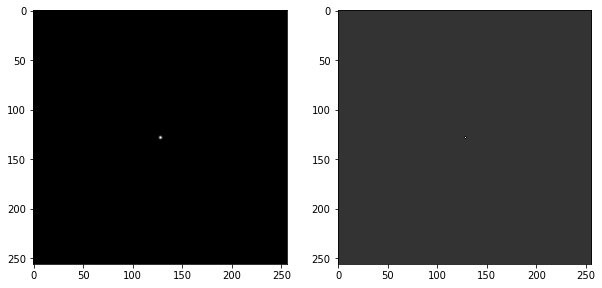

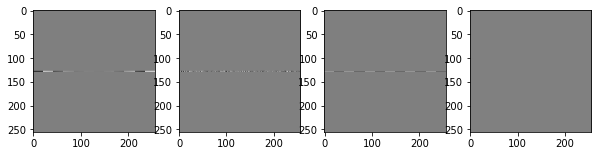

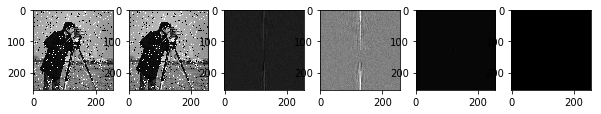

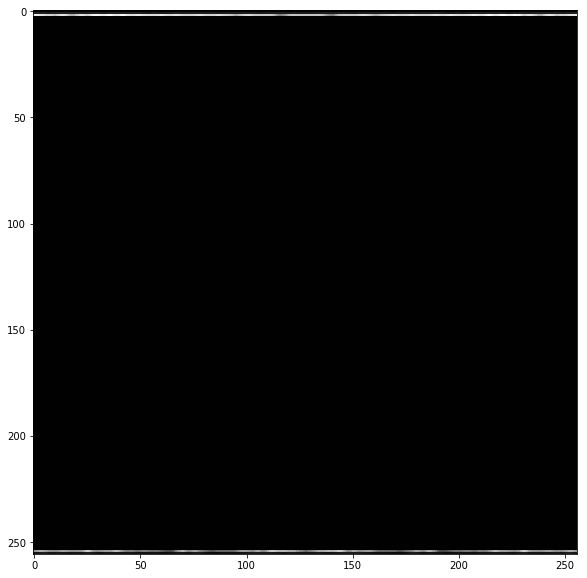

In [20]:
name_reference = str(input()).rstrip()
name_degraded  = str(input()).rstrip()

F = int(input())
if( F == 1 ):
    gamma = float(input())
    size_denoising_filter = int(input())
    denoising_type = str(input())
    f_rest = my_fun(name_reference, name_degraded, F, gamma, np.zeros([size_denoising_filter,size_denoising_filter]), denoising_type, sigma = 0 )
    
    img_reference =igio.imread(name_reference)
    print( my_mse(img_reference, f_rest) )
elif( F == 2 ):
    gamma = float(input())
    size_denoising_filter = int(input())
    sigma = float(input())
    f_rest = my_fun1(name_reference, name_degraded, F, gamma, size_denoising_filter, sigma )

    img_reference =igio.imread(name_reference)
    print( my_mse(img_reference, f_rest) )